In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM, z_at_value
import astropy.units as u

Here we test the method `RedshiftCalculation`, previously included in the `hdpgmm.preprocessing` module using `astropy.cosmology`'s method `z_at_value` as reference. We will use the default cosmological parameters from [Planck et al (2021)](https://www.aanda.org/articles/aa/pdf/2020/09/aa33910-18.pdf) for a spatially flat $\Lambda$CDM cosmology - $H_0 = 67.4$ km s$^{-1}$Mpc$^{-1}$, $\Omega_m = 0.315$.

In [2]:
h = 0.674
om = 0.315
ol = 0.685

def LumDist(z, om, ol, h):
    return 3e3*(z + (1-om +ol)*z**2/2.)/h

def dLumDist(z, om, ol, h):
    return 3e3*(1+(1-om+ol)*z)/h

def RedshiftCalculation(LD, om, ol, h, zinit=0.3, limit = 0.001):
    '''
    Redshift given a certain luminosity, calculated by recursion.
    Limit is the less significative digit.
    '''
    LD_test = LumDist(zinit, om, ol, h)
    if abs(LD-LD_test) < limit :
        return zinit
    znew = zinit - (LD_test - LD)/dLumDist(zinit,om, ol, h)
    return RedshiftCalculation(LD, om, ol, h, zinit = znew)

astropy_cosmo = LambdaCDM(H0 = h*100, Om0 = om, Ode0 = ol)

LD_with_dimensions = np.linspace(0.001,4.5e3,1000)* u.Mpc
LD_no_dimensions   = np.linspace(0.001,4.5e3,1000)

In [3]:
%%time
z_astropy = np.array([z_at_value(astropy_cosmo.luminosity_distance, d) for d in LD_with_dimensions])

CPU times: user 4.4 s, sys: 57.9 ms, total: 4.45 s
Wall time: 4.5 s


In [4]:
%%time
z_RC  = np.array([RedshiftCalculation(d, h, om, 1-om) for d in LD_no_dimensions])

CPU times: user 6.52 ms, sys: 143 µs, total: 6.67 ms
Wall time: 6.63 ms


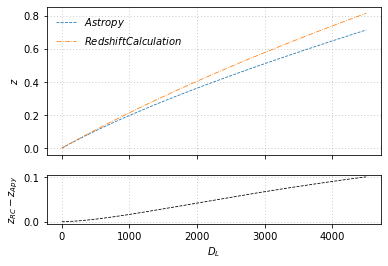

In [6]:
fig, (ax,res) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex = True)
ax.plot(LD_no_dimensions, z_astropy, ls = '--', lw = 0.8, label = "$Astropy$")
ax.plot(LD_no_dimensions, z_RC, ls = '-.', lw = 0.8, label = "$RedshiftCalculation$")
ax.set_ylabel('$z$')
ax.grid(True,dashes=(1,3))
ax.legend(loc = 0, frameon= False)
res.plot(LD_no_dimensions, z_RC-z_astropy, ls = '--', color = 'k', lw = 0.8)
res.set_ylabel('$z_{RC} - z_{Apy}$')
res.set_xlabel('$D_L$')
res.grid(True,dashes=(1,3))

For $D_L\gtrsim 10^3$ Mpc there is an appreciable difference between the second-order approximation made in RedshiftCalculation and Astropy, so it would be good to switch to Astropy's redshift calculation.
The approximated version, however, outperforms Astropy in terms of running time.